### Background of Problem Statement :

The GroupLens Research Project is a research group in the Department of Computer Science and Engineering at the University of Minnesota. Members of the GroupLens Research Project are involved in many research projects related to the fields of information filtering, collaborative filtering, and recommender systems. The project is led by professors John Riedl and Joseph Konstan. The project began to explore automated collaborative filtering in 1992 but is most well known for its worldwide trial of an automated collaborative filtering system for Usenet news in 1996. Since then the project has expanded its scope to research overall information by filtering solutions, integrating into content-based methods, as well as, improving current collaborative filtering technology.

In [1]:
#importing pandas dataframe
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#importing seaborn
import seaborn as sns

#importing pandas profiling 
import pandas_profiling as pf

#importing matplolib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

#importing reg-ex
import re

#Hold out method for splitting data
from sklearn.model_selection import train_test_split

#importing accuracy_score 
from sklearn.metrics import accuracy_score 

#importing LGBMClassifier 
from lightgbm import LGBMClassifier

#importing xgboost
import xgboost

In [2]:
rating = ['UserID','MovieID','Rating','Timestamp']
user = ['UserID','Gender','Age','Occupation','Zip-code']
movie = ['MovieID','Title','Genres']

In [3]:
rating_df = pd.read_csv('ratings.dat',header=None,delimiter='::',names=rating)
print(rating_df.head())
print()
print(rating_df.shape)

   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

(1000209, 4)


In [4]:
user_df = pd.read_csv('users.dat',header=None,delimiter='::',names=user)
print(user_df.head())
print()
print(user_df.shape)

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

(6040, 5)


In [5]:
movie_df = pd.read_csv('movies.dat',header=None,delimiter='::',names=movie)
print(movie_df.head())
print()
print(movie_df.shape)

   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

(3883, 3)


In [6]:
movie_df = pd.read_csv('movies.dat',header=None,delimiter='::',names=movie)
print(movie_df.head())
print()
print(movie_df.shape)

   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

(3883, 3)


### Merging the three datasets

In [7]:
df = rating_df.merge(user_df,how='outer',on='UserID')
df = df.merge(movie_df,how='outer',on='MovieID')
df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1.0,1193,5.0,978300760.0,F,1.0,10.0,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,M,56.0,16.0,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,M,25.0,12.0,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,M,25.0,7.0,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,M,50.0,1.0,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000386 entries, 0 to 1000385
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   UserID      1000209 non-null  float64
 1   MovieID     1000386 non-null  int64  
 2   Rating      1000209 non-null  float64
 3   Timestamp   1000209 non-null  float64
 4   Gender      1000209 non-null  object 
 5   Age         1000209 non-null  float64
 6   Occupation  1000209 non-null  float64
 7   Zip-code    1000209 non-null  object 
 8   Title       1000386 non-null  object 
 9   Genres      1000386 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 84.0+ MB


In [9]:
df.shape

(1000386, 10)

<AxesSubplot:>

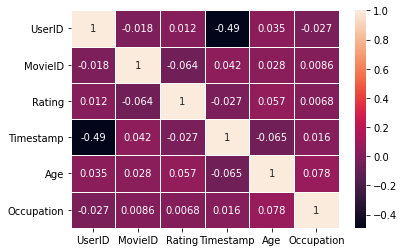

In [10]:
corr = df.corr()
sns.heatmap(corr,annot= True,linewidths=0.5)

### Extracting the pandas profiling report

In [11]:
pfr = pf.ProfileReport(df)
pfr.to_file('Movielens_pfr.html')

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
print('Na values in the data frame is :')
def is_na(x):
    for i in x.columns:
        print(i,'column',' :',x[i].isna().sum(),'\n')
is_na(df)

Na values in the data frame is :
UserID column  : 177 

MovieID column  : 0 

Rating column  : 177 

Timestamp column  : 177 

Gender column  : 177 

Age column  : 177 

Occupation column  : 177 

Zip-code column  : 177 

Title column  : 0 

Genres column  : 0 



In [13]:
df.dropna(inplace=True)

In [14]:
df.Rating.isna().value_counts()

False    1000209
Name: Rating, dtype: int64

In [15]:
def df_unique(X):
    for i in X.columns:
        print('Column : ',i,'\n',X[i].unique(), '\n Total unique values is: ', X[i].nunique())
        print('----------------------------------------------------------------------')
df_unique(df)

Column :  UserID 
 [1.000e+00 2.000e+00 1.200e+01 ... 2.982e+03 3.893e+03 4.211e+03] 
 Total unique values is:  6040
----------------------------------------------------------------------
Column :  MovieID 
 [1193  661  914 ... 2845 3607 2909] 
 Total unique values is:  3706
----------------------------------------------------------------------
Column :  Rating 
 [5. 4. 3. 2. 1.] 
 Total unique values is:  5
----------------------------------------------------------------------
Column :  Timestamp 
 [9.78300760e+08 9.78298413e+08 9.78220179e+08 ... 9.58846401e+08
 9.76029116e+08 9.57273353e+08] 
 Total unique values is:  458455
----------------------------------------------------------------------
Column :  Gender 
 ['F' 'M'] 
 Total unique values is:  2
----------------------------------------------------------------------
Column :  Age 
 [ 1. 56. 25. 50. 18. 45. 35.] 
 Total unique values is:  7
----------------------------------------------------------------------
Column :  Occupati

### Exploring the datasets using visual representations

### Visualizing the User Age Distribution

<AxesSubplot:>

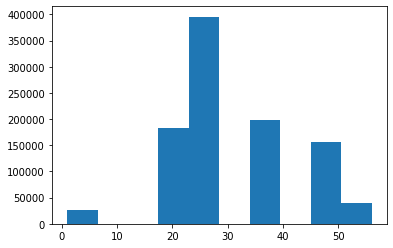

In [16]:
df.Age.hist(grid=False)

### Visualizing User rating of the movie “Toy Story”

In [17]:
def fn(x):
    return re.search("Toy Story".lower(), x.lower())!=None
title = df.iloc[0].Title
title

"One Flew Over the Cuckoo's Nest (1975)"

In [18]:
re_tit = df["Title"].apply(fn)
re_tit.head()

0    False
1    False
2    False
3    False
4    False
Name: Title, dtype: bool

In [19]:
toystory = df[df["Title"].apply(fn)]
toystory

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
41626,1.0,1,5.0,978824268.0,F,1.0,10.0,48067,Toy Story (1995),Animation|Children's|Comedy
41627,6.0,1,4.0,978237008.0,F,50.0,9.0,55117,Toy Story (1995),Animation|Children's|Comedy
41628,8.0,1,4.0,978233496.0,M,25.0,12.0,11413,Toy Story (1995),Animation|Children's|Comedy
41629,9.0,1,5.0,978225952.0,M,25.0,17.0,61614,Toy Story (1995),Animation|Children's|Comedy
41630,10.0,1,5.0,978226474.0,F,35.0,1.0,95370,Toy Story (1995),Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...,...
56826,6022.0,3114,5.0,956755741.0,M,25.0,17.0,57006,Toy Story 2 (1999),Animation|Children's|Comedy
56827,6024.0,3114,4.0,956749447.0,M,25.0,12.0,53705,Toy Story 2 (1999),Animation|Children's|Comedy
56828,6027.0,3114,4.0,956726766.0,M,18.0,4.0,20742,Toy Story 2 (1999),Animation|Children's|Comedy
56829,6036.0,3114,4.0,956710231.0,F,25.0,15.0,32603,Toy Story 2 (1999),Animation|Children's|Comedy


<AxesSubplot:>

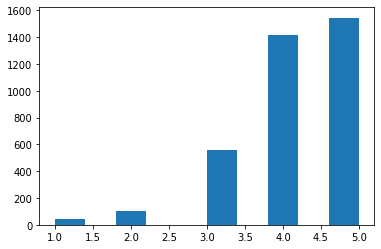

In [20]:
toystory.Rating.hist(grid=False)

### Top 25 movies by viewership rating

In [21]:
top_25 = df.groupby(["MovieID", "Title"]).Timestamp.count().sort_values(ascending=False)
top_25

MovieID  Title                                                
2858     American Beauty (1999)                                   3428
260      Star Wars: Episode IV - A New Hope (1977)                2991
1196     Star Wars: Episode V - The Empire Strikes Back (1980)    2990
1210     Star Wars: Episode VI - Return of the Jedi (1983)        2883
480      Jurassic Park (1993)                                     2672
                                                                  ... 
2218     Juno and Paycock (1930)                                     1
2217     Elstree Calling (1930)                                      1
3382     Song of Freedom (1936)                                      1
2214     Number Seventeen (1932)                                     1
402      Open Season (1996)                                          1
Name: Timestamp, Length: 3706, dtype: int64

In [22]:
print('Top 25 movies by viewership rating')
print(top_25[:25])

Top 25 movies by viewership rating
MovieID  Title                                                
2858     American Beauty (1999)                                   3428
260      Star Wars: Episode IV - A New Hope (1977)                2991
1196     Star Wars: Episode V - The Empire Strikes Back (1980)    2990
1210     Star Wars: Episode VI - Return of the Jedi (1983)        2883
480      Jurassic Park (1993)                                     2672
2028     Saving Private Ryan (1998)                               2653
589      Terminator 2: Judgment Day (1991)                        2649
2571     Matrix, The (1999)                                       2590
1270     Back to the Future (1985)                                2583
593      Silence of the Lambs, The (1991)                         2578
1580     Men in Black (1997)                                      2538
1198     Raiders of the Lost Ark (1981)                           2514
608      Fargo (1996)                             

### The ratings for all the movies reviewed by for a particular user of user id = 2696

In [23]:
usr_2696 = df.loc[df.UserID==2696, "Rating"].sort_values(ascending=False)
usr_2696.head(),usr_2696.shape

(250014    5.0
 603189    4.0
 371178    4.0
 689379    4.0
 618708    4.0
 Name: Rating, dtype: float64,
 (20,))

<AxesSubplot:>

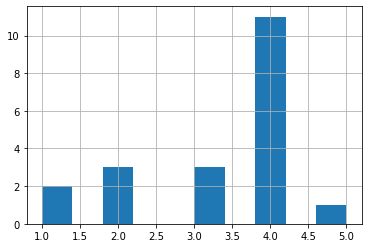

In [24]:
usr_2696.hist()

### Finding all the unique genres

In [25]:
df.Genres.unique()

array(['Drama', "Animation|Children's|Musical", 'Musical|Romance',
       "Animation|Children's|Comedy", 'Action|Adventure|Comedy|Romance',
       'Action|Adventure|Drama', 'Comedy|Drama',
       "Adventure|Children's|Drama|Musical", 'Musical', 'Comedy',
       "Animation|Children's", 'Comedy|Fantasy', 'Animation',
       'Comedy|Sci-Fi', 'Drama|War', 'Romance',
       "Animation|Children's|Musical|Romance",
       "Children's|Drama|Fantasy|Sci-Fi", 'Drama|Romance',
       'Animation|Comedy|Thriller',
       "Adventure|Animation|Children's|Comedy|Musical",
       "Animation|Children's|Comedy|Musical", 'Thriller',
       'Action|Crime|Romance', 'Action|Adventure|Fantasy|Sci-Fi',
       "Children's|Comedy|Musical", 'Action|Drama|War',
       "Children's|Drama", 'Crime|Drama|Thriller', 'Action|Crime|Drama',
       'Action|Adventure|Mystery', 'Crime|Drama',
       'Action|Adventure|Sci-Fi|Thriller',
       'Action|Adventure|Romance|Sci-Fi|War', 'Action|Thriller',
       'Action|Drama', 'Co

In [26]:
Genres_list = df.Genres.tolist()
genre_list = []
i = 0
while(i<len(Genres_list)):
    genre_list+= Genres_list[i].split('|')
    i+=1

In [27]:
unique_gen = list(set(genre_list))
print(unique_gen)
print()
print("Length of the unique Genre : ",len(unique_gen))

['Animation', 'Film-Noir', 'Fantasy', 'Action', 'Horror', 'Drama', 'Documentary', 'War', 'Crime', 'Musical', 'Adventure', "Children's", 'Thriller', 'Western', 'Comedy', 'Sci-Fi', 'Romance', 'Mystery']

Length of the unique Genre :  18


### Creating a separate column for each genre category with a one-hot encoding ( 1 and 0)

In [28]:
new_data = pd.concat([df,df.Genres.str.get_dummies()], axis=1)
print(new_data.columns)

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Gender', 'Age',
       'Occupation', 'Zip-code', 'Title', 'Genres', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [29]:
new_data.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1193,5.0,978300760.0,F,1.0,10.0,48067,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1193,5.0,978298413.0,M,56.0,16.0,70072,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
2,12.0,1193,4.0,978220179.0,M,25.0,12.0,32793,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
3,15.0,1193,4.0,978199279.0,M,25.0,7.0,22903,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
4,17.0,1193,5.0,978158471.0,M,50.0,1.0,95350,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_new = new_data.drop(['Title','Zip-code','Timestamp','Genres'],axis=1)
df_new.head()

,UserID,MovieID,Rating,Gender,Age,Occupation,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1193,5.0,F,1.0,10.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1193,5.0,M,56.0,16.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,1193,4.0,M,25.0,12.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15.0,1193,4.0,M,25.0,7.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17.0,1193,5.0,M,50.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print(df_new.columns)

Index(['UserID', 'MovieID', 'Rating', 'Gender', 'Age', 'Occupation', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


### Encoding the gender column

In [32]:
df_new.Gender = pd.get_dummies(df_new.Gender)

In [33]:
x = df_new.drop(['UserID','MovieID','Rating'],axis=1)
x.shape

(1000209, 21)

### The features affecting the ratings of any particular movie.

In [34]:
print('The features affecting the ratings of any particular movie:')
print()
print(x.columns)

The features affecting the ratings of any particular movie:

Index(['Gender', 'Age', 'Occupation', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western'],
      dtype='object')


In [35]:
y = df_new.Rating
y.shape

(1000209,)

In [36]:
x.Occupation.value_counts()

4.0     131032
0.0     130499
7.0     105425
1.0      85351
17.0     72816
20.0     60397
12.0     57214
2.0      50068
14.0     49109
16.0     46021
6.0      37205
3.0      31623
10.0     23290
15.0     22951
5.0      21850
11.0     20563
19.0     14904
13.0     13754
18.0     12086
9.0      11345
8.0       2706
Name: Occupation, dtype: int64

In [37]:
x = x.join(pd.get_dummies(x.Occupation,prefix='Occupation'))
x.head(),x.columns

(   Gender   Age  Occupation  Action  Adventure  Animation  Children's  Comedy  \
 0       1   1.0        10.0       0          0          0           0       0   
 1       0  56.0        16.0       0          0          0           0       0   
 2       0  25.0        12.0       0          0          0           0       0   
 3       0  25.0         7.0       0          0          0           0       0   
 4       0  50.0         1.0       0          0          0           0       0   
 
    Crime  Documentary  ...  Occupation_11.0  Occupation_12.0  Occupation_13.0  \
 0      0            0  ...                0                0                0   
 1      0            0  ...                0                0                0   
 2      0            0  ...                0                1                0   
 3      0            0  ...                0                0                0   
 4      0            0  ...                0                0                0   
 
    Occupati

In [38]:
x = x.drop(['Occupation','Occupation_0.0'],axis=1)
x.head(3),x.shape

(   Gender   Age  Action  Adventure  Animation  Children's  Comedy  Crime  \
 0       1   1.0       0          0          0           0       0      0   
 1       0  56.0       0          0          0           0       0      0   
 2       0  25.0       0          0          0           0       0      0   
 
    Documentary  Drama  ...  Occupation_11.0  Occupation_12.0  Occupation_13.0  \
 0            0      1  ...                0                0                0   
 1            0      1  ...                0                0                0   
 2            0      1  ...                0                1                0   
 
    Occupation_14.0  Occupation_15.0  Occupation_16.0  Occupation_17.0  \
 0                0                0                0                0   
 1                0                0                1                0   
 2                0                0                0                0   
 
    Occupation_18.0  Occupation_19.0  Occupation_20.0  
 0    

### Deploying the hold out method

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state = 10,stratify=y)

### Deploying the model

In [40]:
lgb = LGBMClassifier(boosting_type = 'gbdt',n_jobs= -1,objective='multiclass')

In [41]:
lgb.fit(x_train,y_train)

LGBMClassifier(objective='multiclass')

In [42]:
y_pred = lgb.predict(x_test)

In [43]:
print('LGBM accuracy score is : ', accuracy_score(y_test,y_pred)*100)

LGBM accuracy score is :  36.32887093710321


In [44]:
xgb = xgboost.XGBClassifier(n_jobs=-1)

In [45]:
xgb.fit(x_train,y_train)

[16:38:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
y_pred_xgb = xgb.predict(x_test)

In [47]:
print('XGB accuracy score is : ', accuracy_score(y_test,y_pred_xgb )*100)

XGB accuracy score is :  36.40635466552024


### Accuracy score of both the model

### LGBM accuracy score is :  36.32887093710321

### XGB accuracy score is : 35.39%